In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [120]:
#Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

Inicialmente, durante uma reunião com o grupo, ficamos incumbidos de responder a essas duas perguntas:

* O preço do metro quadrado (m²) e o valor do condomínio aumentam à medida que o número de quartos aumenta?

* O valor do condomínio varia entre as cidades para apartamentos semelhantes (em termos de número de quartos, banheiros, valor de aluguel, vagas de garagem, etc.)?

Decidimos conduzir nossa análise considerando apenas o valor do aluguel ('rent_amount'), devido à possibilidade de distorção no valor do condomínio, especialmente em situações em que o imóvel está isento de pagamento de condomínio (por ser uma casa) ou nos casos em que o proprietário já inclui o valor do condomínio no montante do aluguel. E em função da distorção do valor do IPTU.


#### Lendo o arquivo tratado

In [121]:
df_bef = pd.read_csv(r"c:\\Users\\gabya\Documents\ADA\\Curso - Data Science\\4. Estatística\\Projeto_EDA\\data\\houses_to_rent_clean.csv")
#df_bef = pd.read_csv(r"/content/drive/MyDrive/Santander Coders/5 - Estatistica/houses_to_rent_clean.csv")
print(df_bef.columns)
df = df_bef.copy()

Index(['city', 'area', 'area_category', 'rooms', 'bathroom', 'parking_spaces',
       'floor', 'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax',
       'area_category_property_tax_median', 'monthly_property_tax',
       'fire_insurance', 'total'],
      dtype='object')


In [122]:
print("\nBanco de dados\n",df.head(3))


Banco de dados
            city  area area_category  rooms  bathroom  parking_spaces  floor  \
0     São Paulo    70      51 a 100      2         1               1      7   
1     São Paulo   320     301 a 350      4         4               0     20   
2  Porto Alegre    80      51 a 100      1         1               1      6   

  animal      furniture   hoa  rent_amount  property_tax  \
0  acept      furnished  2065         3300           211   
1  acept  not furnished  1200         4960          1750   
2  acept  not furnished  1000         2800             0   

   area_category_property_tax_median  monthly_property_tax  fire_insurance  \
0                               84.0                 211.0              42   
1                              996.0                1750.0              63   
2                               54.0                   0.0              41   

   total  
0   5618  
1   7973  
2   3841  


#### Abordagem

Decidimos realizar uma análise de correlação para compreender quais variáveis estão mais relacionadas. Para isso, utilizamos um mapa de calor (heatmap) de forma abrangente, incluindo todas as variáveis numéricas.

O coeficiente de correlação varia de -1 a 1, onde:

1: Correlação positiva perfeita - quando uma variável aumenta, a outra também aumenta de forma perfeitamente proporcional.

0: Ausência de correlação linear - não há relação linear entre as variáveis.

-1: Correlação negativa perfeita - quando uma variável aumenta, a outra diminui de forma perfeitamente proporcional.



In [123]:
#separando as variáveis numéricas e categóricas.
numericas,categoricas=[],[]
for i in df:
    if df[i].dtype == object:
        categoricas.append(i)
    else:
        numericas.append(i)
print(f"As variáveis numéricas são: {numericas}")
print(f"As variáveis categoricas são: {categoricas}")


As variáveis numéricas são: ['area', 'rooms', 'bathroom', 'parking_spaces', 'floor', 'hoa', 'rent_amount', 'property_tax', 'area_category_property_tax_median', 'monthly_property_tax', 'fire_insurance', 'total']
As variáveis categoricas são: ['city', 'area_category', 'animal', 'furniture']


<Axes: >

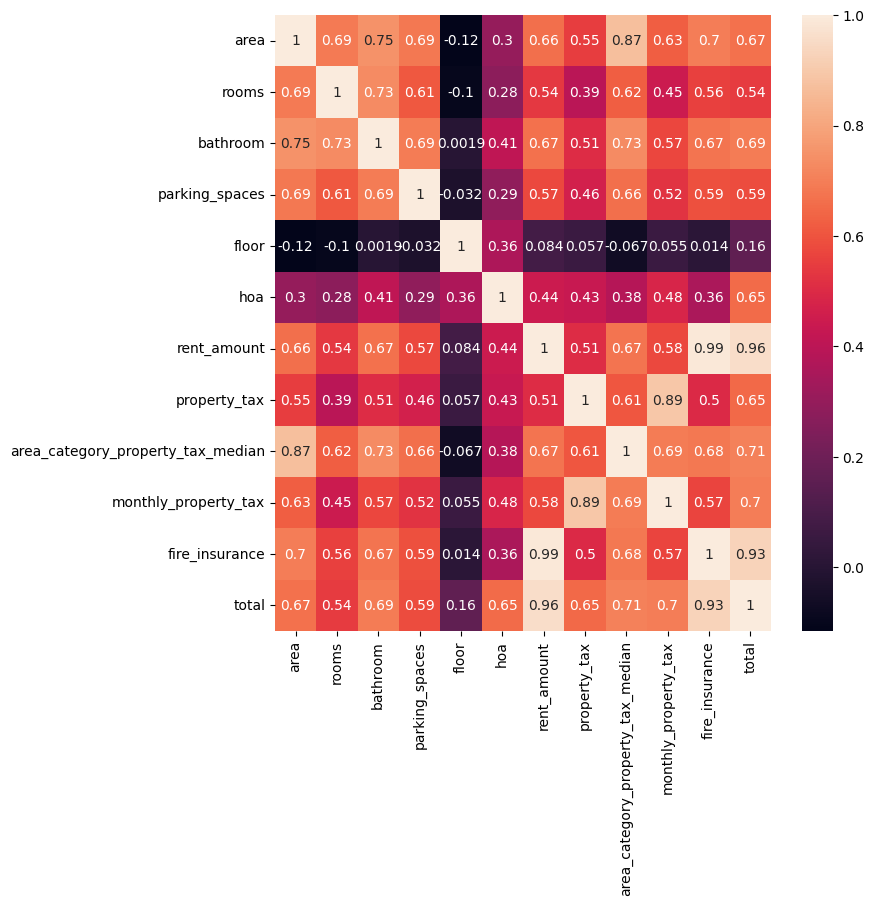

In [124]:
# grafico de Heatmap para vizualização das correlações gerais
plt.figure(figsize =(8,8))
cor = df[numericas].corr()
sns.heatmap(cor,annot =True)

### One-Hot-Encoding

A fim de explorar as variáveis categóricas, fazemos uso do One-Hot Encoding, uma técnica de pré-processamento comumente utilizada em aprendizado de máquina para lidar com variáveis categóricas (ou qualitativas). Em vez de representar categorias como números, o One-Hot Encoding converte cada categoria única em uma nova coluna (ou variável) binária.

Neste caso, fizemos o pré-processamento nas variáveis 'city', 'animal' e 'furniture', para utilizá-las no análise de correlação e na Regressão Linear (que será abordada posteriormente).

In [125]:
## Pré-processamento Para transformar as variáveis categóricas em variáveis numérica e poder fazer as correlações

# OneHotEncoding em City, Animal, Furniture
col_one_hot_encoding = ['city', 'animal', 'furniture']

# Aplica one-hot encoding nas colunas selecionadas
df = pd.get_dummies(df, columns=col_one_hot_encoding)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10317 entries, 0 to 10316
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   area                               10317 non-null  int64  
 1   area_category                      10317 non-null  object 
 2   rooms                              10317 non-null  int64  
 3   bathroom                           10317 non-null  int64  
 4   parking_spaces                     10317 non-null  int64  
 5   floor                              10317 non-null  int64  
 6   hoa                                10317 non-null  int64  
 7   rent_amount                        10317 non-null  int64  
 8   property_tax                       10317 non-null  int64  
 9   area_category_property_tax_median  10317 non-null  float64
 10  monthly_property_tax               10317 non-null  float64
 11  fire_insurance                     10317 non-null  int

In [129]:
# Para essa análise vamos fazer as correlações entre as variáveis em especial as variáveis área, numero de quartos, numero de banheiros e vagas de estacionamento.
# Relacionando elas com a variável aluguel.
var_esc = ['area', 'rooms', 'bathroom', 'parking_spaces', 'rent_amount']

df_corr = df.drop('area_category', axis = 1).copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10317 entries, 0 to 10316
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   area                               10317 non-null  int64  
 1   area_category                      10317 non-null  object 
 2   rooms                              10317 non-null  int64  
 3   bathroom                           10317 non-null  int64  
 4   parking_spaces                     10317 non-null  int64  
 5   floor                              10317 non-null  int64  
 6   hoa                                10317 non-null  int64  
 7   rent_amount                        10317 non-null  int64  
 8   property_tax                       10317 non-null  int64  
 9   area_category_property_tax_median  10317 non-null  float64
 10  monthly_property_tax               10317 non-null  float64
 11  fire_insurance                     10317 non-null  int

In [130]:
print(df_corr.corr())

                                       area     rooms  bathroom  \
area                               1.000000  0.689222  0.750926   
rooms                              0.689222  1.000000  0.730082   
bathroom                           0.750926  0.730082  1.000000   
parking_spaces                     0.685488  0.610902  0.693000   
floor                             -0.115524 -0.100523  0.001919   
hoa                                0.299847  0.279545  0.411660   
rent_amount                        0.660822  0.535311  0.665219   
property_tax                       0.548338  0.394909  0.505306   
area_category_property_tax_median  0.873612  0.622155  0.734186   
monthly_property_tax               0.625239  0.445848  0.571408   
fire_insurance                     0.696804  0.559657  0.673280   
total                              0.668204  0.542705  0.692189   
city_Belo Horizonte                0.083099  0.164189  0.043353   
city_Campinas                     -0.042158 -0.044824 -0.06120

<Axes: >

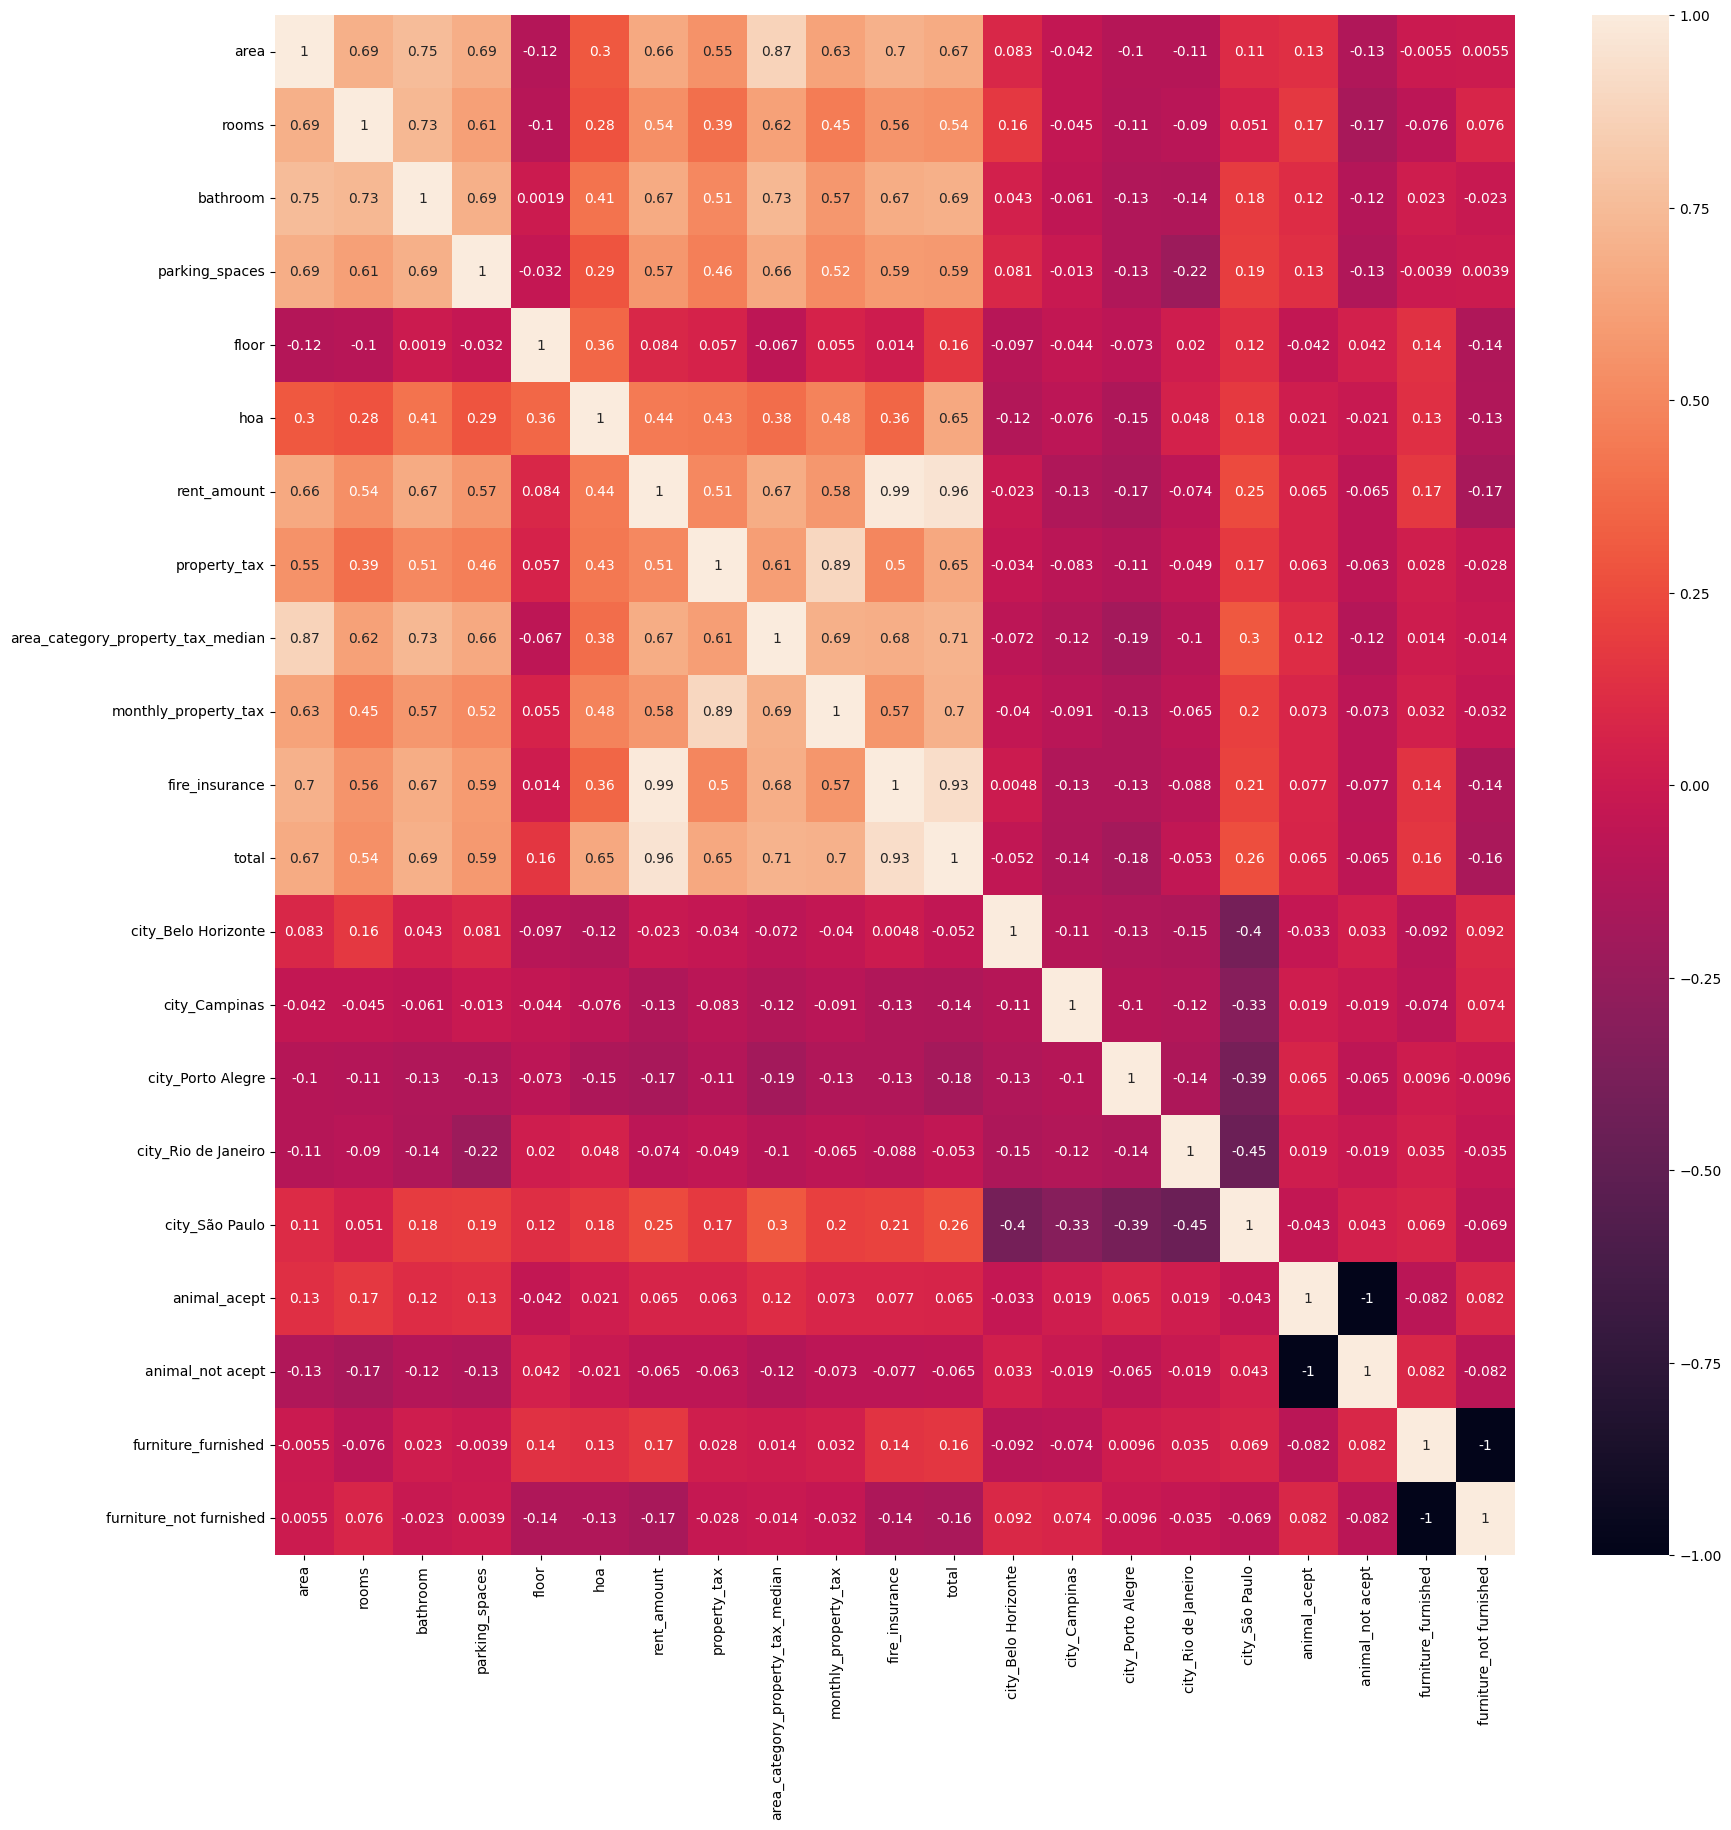

In [131]:
# grafico de Heatmap para vizualização das correlações gerais
plt.figure(figsize =(20,20))
cor = df_corr.corr()
sns.heatmap(cor,annot =True)

<Axes: >

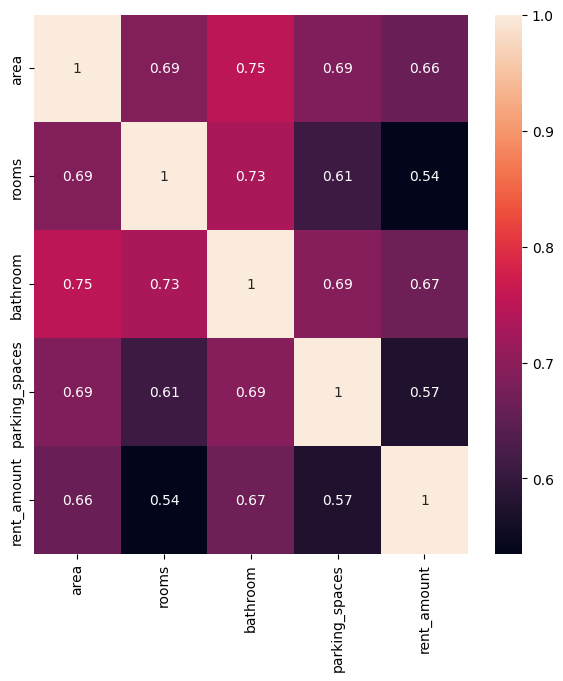

In [132]:
#criando o mapa de calor para uma melhor vizualização das correlações
plt.figure(figsize =(7,7))
cor = df[var_esc].corr()
sns.heatmap(cor,annot =True)

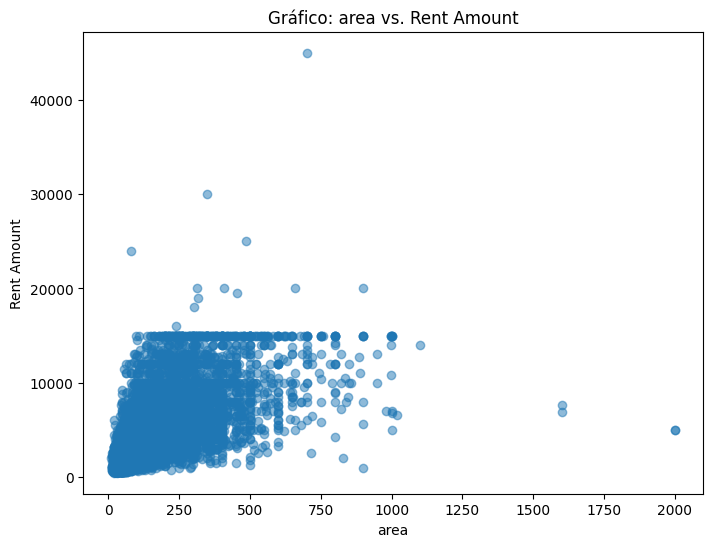

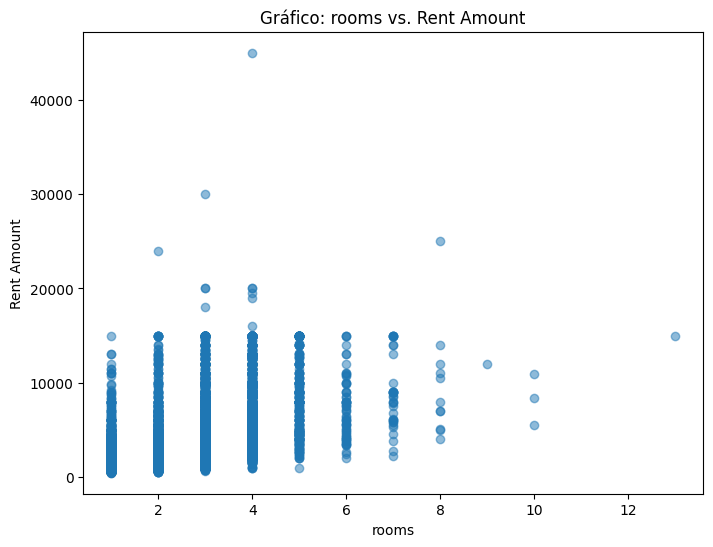

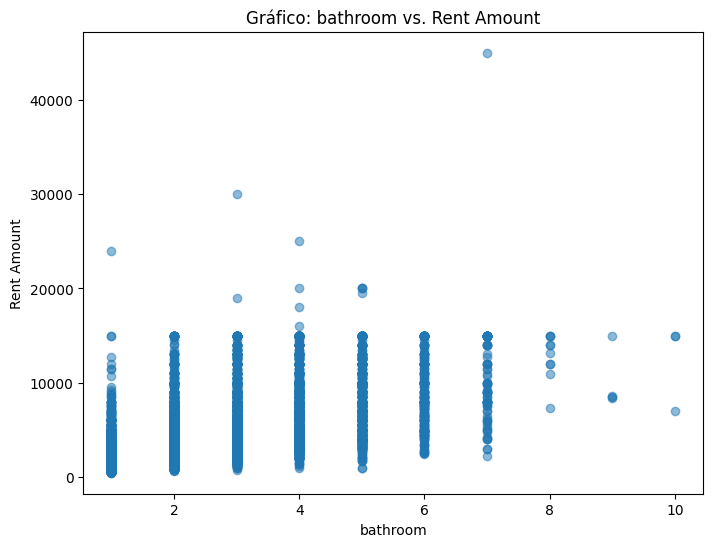

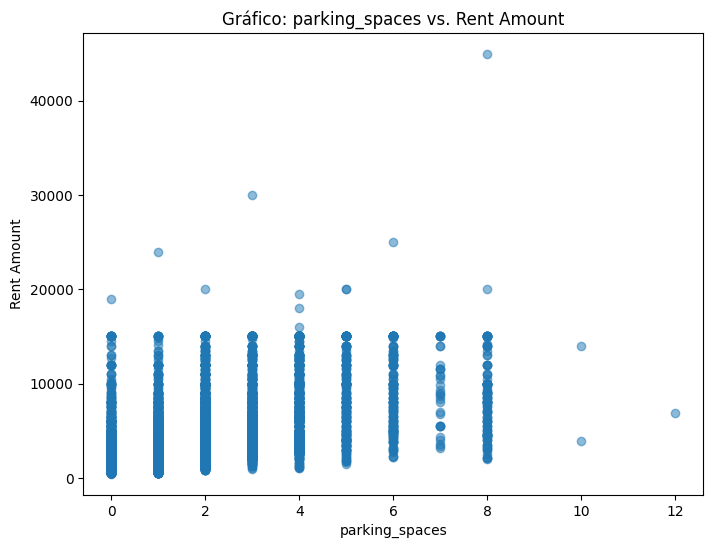

In [133]:
# Criando os Gráficos para vizualizar as correlações das variáveis área, número de quartos, número de banheiros, vagas de estacionamênto com o valor do aluguel.
for variavel in var_esc [:-1]:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[variavel], df['rent_amount'], alpha=0.5)
    plt.xlabel(variavel)
    plt.ylabel('Rent Amount')
    plt.title(f'Gráfico: {variavel} vs. Rent Amount')
    plt.show()


## Regressão Linear

Utilizando a biblioteca Scikit-Learn (sklearn) do Python, fizemos uso da regressão linear, uma técnica de aprendizado de máquina utilizada para modelar a relação entre uma variável dependente (ou variável alvo) e uma ou mais variáveis independentes, assumindo uma relação linear entre elas.

Sendo assim, a fim de tentar realizar a previsão da variável 'rent_amount' (variável dependente), fizemos uso das variáveis 'area', 'floor', 'bathrooms', 'rooms', 'parking_spaces', 'city' (pós-one-hot-encoding), 'animal' (pós-one-hot-encoding) e 'furniture' (pós-one-hot-encoding), variáveis independentes.

A equação da regressão linear é representada como:

 y = mx + b 

Onde:
- \( y \) é a variável dependente (ou variável alvo),
- \( x \) é a variável independente,
- \( m \) é o coeficiente angular (inclinação) da linha de regressão,
- \( b \) é o coeficiente linear (intercepto) da linha de regressão.

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10317 entries, 0 to 10316
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   area                               10317 non-null  int64  
 1   area_category                      10317 non-null  object 
 2   rooms                              10317 non-null  int64  
 3   bathroom                           10317 non-null  int64  
 4   parking_spaces                     10317 non-null  int64  
 5   floor                              10317 non-null  int64  
 6   hoa                                10317 non-null  int64  
 7   rent_amount                        10317 non-null  int64  
 8   property_tax                       10317 non-null  int64  
 9   area_category_property_tax_median  10317 non-null  float64
 10  monthly_property_tax               10317 non-null  float64
 11  fire_insurance                     10317 non-null  int

In [135]:
# Removendo colunas desnecessárias para a análise

ind_col_drop = [1, 6, 8, 9, 10, 11, 12]
df.drop(df.columns[ind_col_drop], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10317 entries, 0 to 10316
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   area                     10317 non-null  int64
 1   rooms                    10317 non-null  int64
 2   bathroom                 10317 non-null  int64
 3   parking_spaces           10317 non-null  int64
 4   floor                    10317 non-null  int64
 5   rent_amount              10317 non-null  int64
 6   city_Belo Horizonte      10317 non-null  bool 
 7   city_Campinas            10317 non-null  bool 
 8   city_Porto Alegre        10317 non-null  bool 
 9   city_Rio de Janeiro      10317 non-null  bool 
 10  city_São Paulo           10317 non-null  bool 
 11  animal_acept             10317 non-null  bool 
 12  animal_not acept         10317 non-null  bool 
 13  furniture_furnished      10317 non-null  bool 
 14  furniture_not furnished  10317 non-null  bool 
dtypes:

Realizando a implementação de uma técnica chamada **divisão de dados em conjunto de treino e conjunto de teste**. 

Esta técnica é fundamental em aprendizado de máquina para avaliar o desempenho de um modelo em dados não vistos durante o treinamento, a fim de evitar que o modelo se ajuste demasiadamente aos dados de treino, capturando até mesmo o ruído nos dados. 

1. **`x` e `y`**: São os conjuntos de dados divididos. `x` representa as variáveis independentes (ou recursos) e `y` representa a variável dependente (ou alvo).

2. **`test_size=0.2`**: Este argumento define a proporção dos dados que serão atribuídos ao conjunto de teste. Neste caso, 20% dos dados serão usados para teste, enquanto 80% serão usados para treinamento.

3. **`random_state=0`**: O `random_state` é uma semente (seed) para o gerador de números aleatórios. Fornecer um valor fixo para `random_state` garante que a divisão dos dados seja sempre a mesma, permitindo a reproducibilidade.

4. **`x_train, x_test, y_train, y_test`**: São as variáveis que armazenam os conjuntos de dados divididos. `x_train` e `y_train` contêm os dados de treino para as variáveis independentes e dependentes, respectivamente. `x_test` e `y_test` contêm os dados de teste para as variáveis independentes e dependentes, respectivamente.

In [136]:
# Separando os dados
x = df.drop(['rent_amount'], axis = 1)
y = df.rent_amount

# Separação dos dados de testes e treino de forma aleatória
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Agora, tem-se a criação do objeto de Regressão Linear e o seu treinamento.

A partir disso, podemos verificar o seu \( R^2 \), o coeficiente de determinação, que representa a proporção da variância na variável dependente que é previsível a partir das variáveis independentes em um modelo de regressão. Quanto mais próximo o valor de \( R^2 \) estiver de 1, melhor o modelo de regressão se ajusta aos dados. Se \( R^2 \) é 0.8, por exemplo, isso significa que 80% da variabilidade nos dados da variável dependente pode ser explicada pelas variáveis independentes no modelo de regressão.

In [137]:
#Criando um Objeto de Regressão Linear
lr = LinearRegression()

#Treinando o Modelo
lr.fit(x_train,y_train)

#Verificando o resultado
r_sq = lr.score(x, y)
print('Coeficiente de Determinação (R²):', r_sq)

Coeficiente de Determinação (R²): 0.564996606765281


A partir disso, tem-se a extração do intercepto e dos coeficientes das variáveis independentes, a fim de entender quais variáveis mais ou menos impactam o resultado final do 'rent_amount', o aluguel.

1. `intercepto = lr.intercept_`: Após treinar um modelo de regressão linear, o objeto `lr` contém informações sobre o modelo ajustado. O intercepto (também conhecido como coeficiente linear) representa o valor da variável dependente quando todas as variáveis independentes são zero. Nesta linha, o valor do intercepto é extraído do modelo e armazenado na variável `intercepto`.

2. `coeff_df = pd.DataFrame(lr.coef_, x.columns, columns=['Coefficient'])`: `lr.coef_` contém os coeficientes das variáveis independentes. `x.columns` contém os nomes das variáveis independentes (ou recursos). Esta linha cria um DataFrame do pandas (`coeff_df`) com os coeficientes e os nomes das variáveis independentes como índices. O argumento `columns=['Coefficient']` define o nome da coluna no DataFrame para armazenar os coeficientes.

In [138]:
intercepto = lr.intercept_
print('Intercepto:', intercepto)

coeff_df = pd.DataFrame(lr.coef_,x.columns,columns=['Coefficient'])
coeff_df.head(14)

Intercepto: 110.44804519782565


,Coefficient
area,9.345448
rooms,136.581986
bathroom,636.366854
parking_spaces,249.086697
floor,59.021717
city_Belo Horizonte,-221.780093
city_Campinas,-647.878084
city_Porto Alegre,-341.123756
city_Rio de Janeiro,526.913504
city_São Paulo,683.868430


O resultado do DataFrame acima revela que as variáveis relacionadas ao banheiro e à cidade de São Paulo são as que mais impactam no valor do aluguel. Enquanto isso, as variáveis voltadas à cidade de Campinas, e à falta de mobílias seguem o caminho oposto.

### Avaliando Erros

Agora calcularemos e imprimiremos diferentes métricas de erro para avaliar o desempenho do nosso modelo de regressão linear. 

1. `y_pred = lr.predict(x_test)`: Nesta linha, o modelo de regressão linear (`lr`) faz previsões usando os dados de teste (`x_test`). As previsões são armazenadas na variável `y_pred`. Em outras palavras, o modelo está prevendo os valores da variável dependente com base nos dados de teste.

2. `print('MAE:', metrics.mean_absolute_error(y_test, y_pred))`: A média do erro absoluto (MAE) é uma métrica que calcula a média das diferenças absolutas entre as previsões (`y_pred`) e os valores reais (`y_test`). Quanto menor o valor do MAE, melhor o modelo está performando em termos de erro absoluto.

3. `print('MSE:', metrics.mean_squared_error(y_test, y_pred))`: O erro quadrático médio (MSE) é uma métrica que calcula a média das diferenças ao quadrado entre as previsões e os valores reais. O MSE dá mais peso a erros maiores. Quanto menor o MSE, melhor o modelo está performando em termos de erro quadrático.

4. `print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))`: A raiz do erro quadrático médio (RMSE) é a raiz quadrada do MSE. O RMSE é uma métrica de erro que tem as mesmas unidades que a variável dependente, o que facilita a interpretação. Quanto menor o RMSE, melhor o modelo está performando em termos de erro quadrático, mas agora na escala original dos dados.

Essas métricas de erro são essenciais para avaliar a precisão do modelo de regressão. 

In [139]:
y_pred = lr.predict(x_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


MAE: 1458.787302962678
MSE: 5081419.922282939
RMSE: 2254.2005062289686


### Gráfico da Regressão Linear

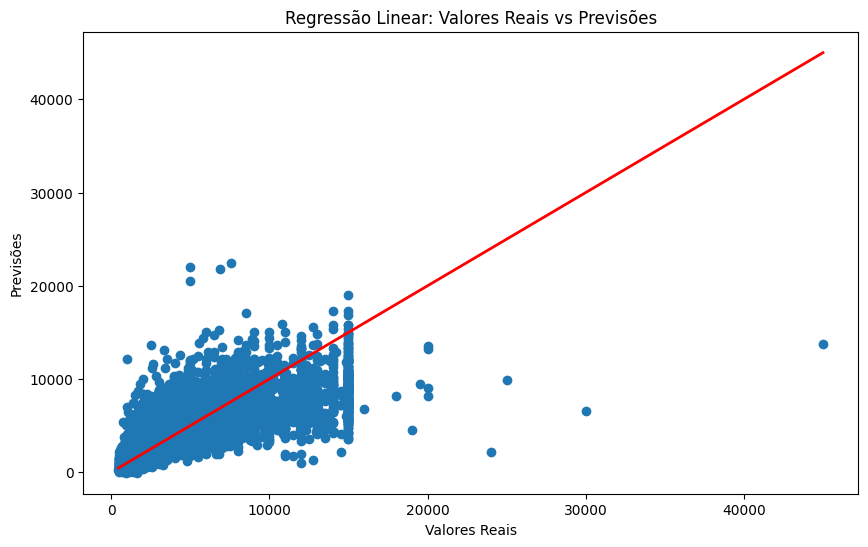

In [140]:
previsoes = lr.predict(x)
plt.figure(figsize=(10, 6))
plt.scatter(y, previsoes)
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("Regressão Linear: Valores Reais vs Previsões")
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linewidth=2, linestyle='-')
plt.show()